# Chemical species

**Objectives**

- Learn how to define chemical species in FESTIM
- Understand the concept of implicit species

## Define explicit species

In FESTIM, *explicit* species are species which concentrations are explicitly governed by a PDE in the governing equations.

For example, if consider the following problem:

\begin{align}
    \frac{\partial c_1}{\partial t} &= \nabla \cdot (D_1 \nabla c_1)\\
    \frac{\partial c_2}{\partial t} &= \nabla \cdot (D_2 \nabla c_2)
\end{align}


In this case, the concentration of species 1 and 2 (namely $c_1$ and $c_2$) are governed by a PDE. Species 1 and 2 are *explicit* species. In addition, they are mobile species since their governing equations exhibit a diffusive term.

In a FESTIM model, these species would be defined using the ``F.Species`` class:


In [1]:
import festim as F

my_model = F.HydrogenTransportProblem()

species_1 = F.Species(name="Species 1", mobile=True)
species_2 = F.Species(name="Species 2", mobile=True)

my_model.species = [species_1, species_2]

````{margin}
```{admonition} Note
``mobile`` is ``True`` by default.
``` 
````

Here's another problem:

\begin{align}
    \frac{\partial c_1}{\partial t} &= \nabla \cdot (D_1 \nabla c_1) - k c_1 c_2 + p c_3\\
    \frac{\partial c_2}{\partial t} &= -k c_1 c_2 + p c_3\\
    \frac{\partial c_3}{\partial t} &= k c_1 c_2 - p c_3
\end{align}



Here again, all species (1, 2, and 3) are explicitly accounted for in the governing equations. The three PDEs are coupled by a reaction. For more information on reactions, have a look at the [Reactions](reactions.ipynb) tutorial.

This time Species 2 and 3 are immobile (ie. their governing equation don't have a diffusive term).

The species would therefore be defined as:

In [2]:
my_model = F.HydrogenTransportProblem()

species_1 = F.Species(name="Species 1")
species_2 = F.Species(name="Species 2", mobile=False)
species_3 = F.Species(name="Species 3", mobile=False)

my_model.species = [species_1, species_2]

## Implicit species

In some cases where we don't want to explicitly define some species. Consider the following problem:

\begin{align}
    \frac{\partial c_1}{\partial t} &= \nabla \cdot (D_1 \nabla c_1) - k c_1 c_2 + p c_3\\
    \frac{\partial c_3}{\partial t} &= k c_1 c_2 - p c_3
\end{align}



If we express $c_2$ as:



\begin{equation}
    c_2 = n - c_3
\end{equation}



And if we assume that $n$ is known, then governing equations can therefore be written as:

\begin{align}
    \frac{\partial c_1}{\partial t} &= \nabla \cdot (D_1 \nabla c_1) - k c_1 (n-c_3) + p c_3\\
    \frac{\partial c_3}{\partial t} &= k c_1 (n-c_3) - p c_3
\end{align}



Species 2 is, in this case, an *implicit* species. That is because its concentration can be directly expressed form other concentrations (here, $n$ and $c_3$).

In [3]:
my_model = F.HydrogenTransportProblem()

species_1 = F.Species(name="Species 1")
species_3 = F.Species(name="Species 3", mobile=False)

species_2 = F.ImplicitSpecies(name="Species 2", n=20, others=[species_3])

# only pass explicit species to the model
my_model.species = [species_1, species_3]

In this case, $n$ can be any function of space and time. For example, $n=2 x + y + 20 \ t$:

In [4]:
def n_fun(x, t):
    return 2 * x[0] + x[1] + 20 * t

species_2 = F.ImplicitSpecies(name="Species 2", n=n_fun, others=[species_3])

or in a more compact form:

In [5]:
species_2 = F.ImplicitSpecies(
    name="Species 2",
    n=lambda x, t: 2 * x[0] + x[1] + 20 * t,
    others=[species_3],
)

Using implicit species is useful for reducing the number of degrees of freedom in a problem.

```{warning} 
``ImplicitSpecies`` isn't suitable for mobile species. That's because their concentration cannot be expressed from other concentrations.
```

## Complete example

We consider the following problem on a 1D domain:

\begin{align}
    \frac{\partial c_H}{\partial t} &= \nabla \cdot (D \nabla c_H)\\
    \frac{\partial c_D}{\partial t} &= \nabla \cdot (D \nabla c_D)\\
    \frac{\partial c_T}{\partial t} &= \nabla \cdot (D \nabla c_T)\\
\end{align}

For simplicity, we assume that all three species have the same diffusivity.

Fixed concentration boundary conditions are set on both surfaces.

In [6]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

protium = F.Species("H")
deuterium = F.Species("D")
tritium = F.Species("T")
my_model.species = [protium, deuterium, tritium]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

# assumes the same diffusivity for all species
material = F.Material(D_0=1, E_D=0)

vol = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=material)

my_model.subdomains = [vol, left_surf, right_surf]

my_model.boundary_conditions = [
    # Protium BCs
    F.FixedConcentrationBC(left_surf, value=10, species=protium),
    F.FixedConcentrationBC(right_surf, value=0, species=protium),
    # Deuterium BCs
    F.FixedConcentrationBC(left_surf, value=5, species=deuterium),
    F.FixedConcentrationBC(right_surf, value=0, species=deuterium),
    # Tritium BCs
    F.FixedConcentrationBC(left_surf, value=0, species=tritium),
    F.FixedConcentrationBC(right_surf, value=2, species=tritium),
]

my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=100)

my_model.settings.stepsize = F.Stepsize(1)

In [7]:
my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/100 [00:00<?, ?it/s]

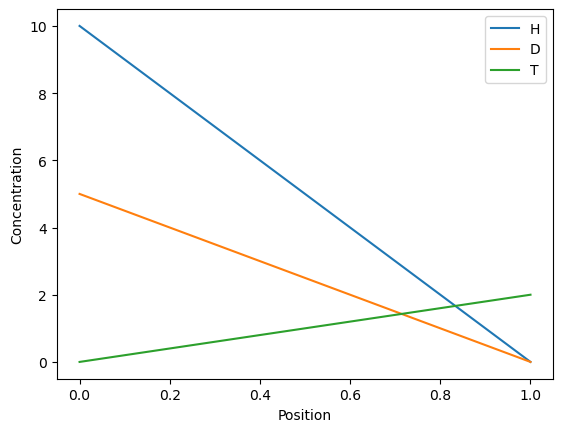

In [8]:
import matplotlib.pyplot as plt

def plot_profile(species, **kwargs):
    c = species.post_processing_solution.x.array[:]
    x = species.post_processing_solution.function_space.mesh.geometry.x[:,0]
    return plt.plot(x, c, **kwargs)

for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()